In [1]:
## Required packages
import random
import spacy
import pandas as pd
import seaborn as sns
from spacy.util import minibatch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

## Paths
data_path = "spam.csv"

## Configurations
sns.set(style="darkgrid")

## UDF's
def train_model(model, train_data, optimizer, batch_size, epochs=10):
    losses = {}
    random.seed(1)

    for epoch in range(epochs):
        random.shuffle(train_data)

        batches = minibatch(train_data, size=batch_size)
        for batch in batches:
            # Split batch into texts and labels
            texts, labels = zip(*batch)

            # Update model with texts and labels
            model.update(texts, labels, sgd=optimizer, losses=losses)
        # print("Loss: {}".format(losses['textcat']))

    return losses['textcat']

def get_predictions(model, texts):
    # Use the model's tokenizer to tokenize each input text
    docs = [model.tokenizer(text) for text in texts]

    # Use textcat to get the scores for each doc
    textcat = model.get_pipe('textcat')
    scores, _ = textcat.predict(docs)

    # From the scores, find the label with the highest score/probability
    predicted_labels = scores.argmax(axis=1)
    predicted_class = [textcat.labels[label] for label in predicted_labels]

    return predicted_class


Train accuracy: 0.998928475756764
Test accuracy: 0.9815116911364872


In [3]:
# Load dataset
data = pd.read_csv(data_path)
observations = len(data.index)
# print("Dataset Size: {}".format(observations))

# Create an empty spacy model
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
text_cat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Adding the TextCategorizer to the created empty model
nlp.add_pipe(text_cat)

# Add labels to text classifier
text_cat.add_label("ham")
text_cat.add_label("spam")

# Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.33, random_state=7)

# Create the train and test data for the spacy model
train_lables = [{'cats': {'ham': label == 'ham',
                          'spam': label == 'spam'}}  for label in y_train]
test_lables = [{'cats': {'ham': label == 'ham',
                      'spam': label == 'spam'}}  for label in y_test]

# Spacy model data
train_data = list(zip(x_train, train_lables))
test_data = list(zip(x_test, test_lables))

# Model configurations
optimizer = nlp.begin_training()
batch_size = 5
epochs = 10

# Training the model
train_model(nlp, train_data, optimizer, batch_size, epochs)

# Sample predictions
# print(train_data[0])
# sample_test = nlp(train_data[0][0])
# print(sample_test.cats)

# Train and test accuracy
train_predictions = get_predictions(nlp, x_train)
test_predictions = get_predictions(nlp, x_test)
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.998928475756764
Test accuracy: 0.9815116911364872


<AxesSubplot:>

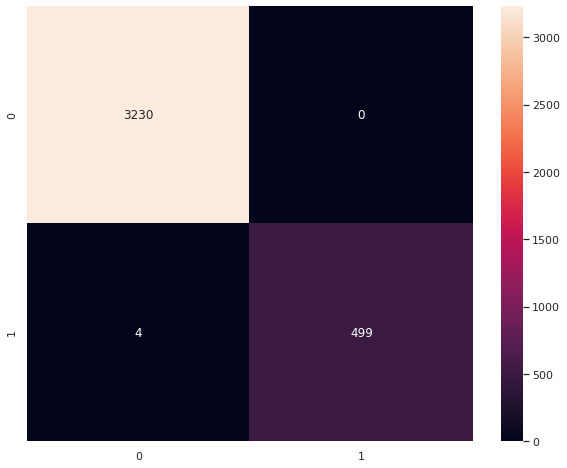

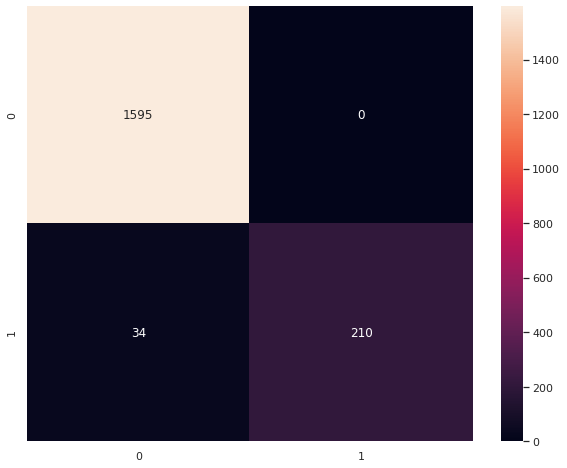

In [5]:
# Creating the confusion matrix graphs
cf_train_matrix = confusion_matrix(y_train, train_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_train_matrix, annot=True, fmt='d')

cf_test_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')